In [1]:
import pickle
from icecream import ic
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from pca import pca
from sklearn.metrics import ConfusionMatrixDisplay
import open3d as o3d

from dataloader import TrainLoader, read_txt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Train

In [2]:
def run_pca(xs, ratio, to_file=None):
    values = []
    for x in tqdm(xs):
        model = PCA()
        model.fit_transform(x)
        if ratio:
            values.append(min(model.explained_variance_ratio_))
        else:
            values.append(min(model.explained_variance_))
    values = np.array(values)
    if to_file is not None:
        pickle.dump(values, open(to_file, 'wb'))
    return values


def sample_min_variance_ratio(N):
    a = {}
    loader = TrainLoader(root='./dataset/txt/training/pointCloud')
    for label in range(1, 6):
        xs = loader.sample(N, label, points_only=True)
        a[label] = run_pca(xs, ratio=True, to_file=f'./pkl/min_variance_ratio_{label}_{N}.pkl')
    return a


def sample_min_variance(N):
    a = {}
    loader = TrainLoader(root='./dataset/txt/training/pointCloud')
    for label in range(1, 6):
        xs = loader.sample(N, label, points_only=True)
        a[label] = run_pca(xs, ratio=False, to_file=f'./pkl/min_variance_{label}_{N}.pkl')
    return a

In [3]:
# a = sample_min_variance(46000 // 5)
a = {}
for label in range(1, 6):
    a[label] = pickle.load(open(f'./pkl/min_variance_ratio_{label}_9200.pkl', 'rb'))

In [4]:
plane_var = a[1]
other_var = np.concatenate([a[2], a[3], a[4], a[5]])

In [14]:
threshold = ((other_var.mean() - other_var.std()) + (plane_var.mean() + plane_var.std())) / 2
threshold = 5e-3
# threshold = plane_var.mean() + plane_var.std()
# threshold = other_var.mean() - other_var.std()
TP = (plane_var <= threshold).sum() / 460
FP = (other_var <= threshold).sum() / 460
FN = (plane_var > threshold).sum() / 460
TN = (other_var > threshold).sum() / 460
ic(threshold)

ic| threshold: 0.005


0.005

In [15]:
TP + TN

93.72826086956522

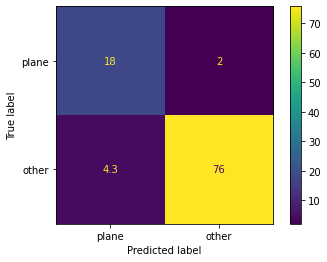

In [16]:
cm = np.array([[TP, FN], [FP, TN]]) 
ls = ['plane', 'other']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot()
plt.show()

## Generate results

In [28]:
threshold

0.1

In [29]:
def test():
    filepath = './dataset/ply/test/pointCloud/pointCloud%d.ply'
    plane_ids = []
    for id in tqdm(range(1, 926)):
        x = np.asarray(o3d.io.read_point_cloud(filepath % id).points)
        model = PCA()
        model.fit_transform(x)
        if min(model.explained_variance_ratio_) <= threshold:
            plane_ids.append(id)
    
    with open('./results/plane_ids.txt', 'w') as f:
        f.write('\n'.join(map(str, plane_ids)))
    return plane_ids

plane_ids = test()

  0%|          | 0/925 [00:00<?, ?it/s]

In [30]:
is_plane = [0 for i in range(925)]
for id in plane_ids:
    is_plane[id - 1] = 1

with open('./results/is_plane.txt', 'w') as f:
    f.write('\n'.join(map(str, is_plane)))